In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot


from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
age_details = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/AgeGroupDetails.csv', sep=",")
india_covid_19 = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/covid_19_india.csv')
hospital_beds = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/HospitalBedsIndia.csv')
individual_details = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/IndividualDetails.csv')
ICMR_details = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/ICMRTestingLabs.csv')
state_testing = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/StatewiseTestingDetails.csv')
population = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-in-india/population_india_census2011.csv')

world_population = pd.read_csv(r'https://raw.githubusercontent.com/swathihameed/COVID/master/population-by-country-2020/population_by_country_2020.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])
ICMR_details['DateTime'] = pd.to_datetime(ICMR_details['DateTime'],dayfirst = True)
ICMR_details = ICMR_details.dropna(subset=['TotalSamplesTested', 'TotalPositiveCases'])

In [5]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered + world_deaths)

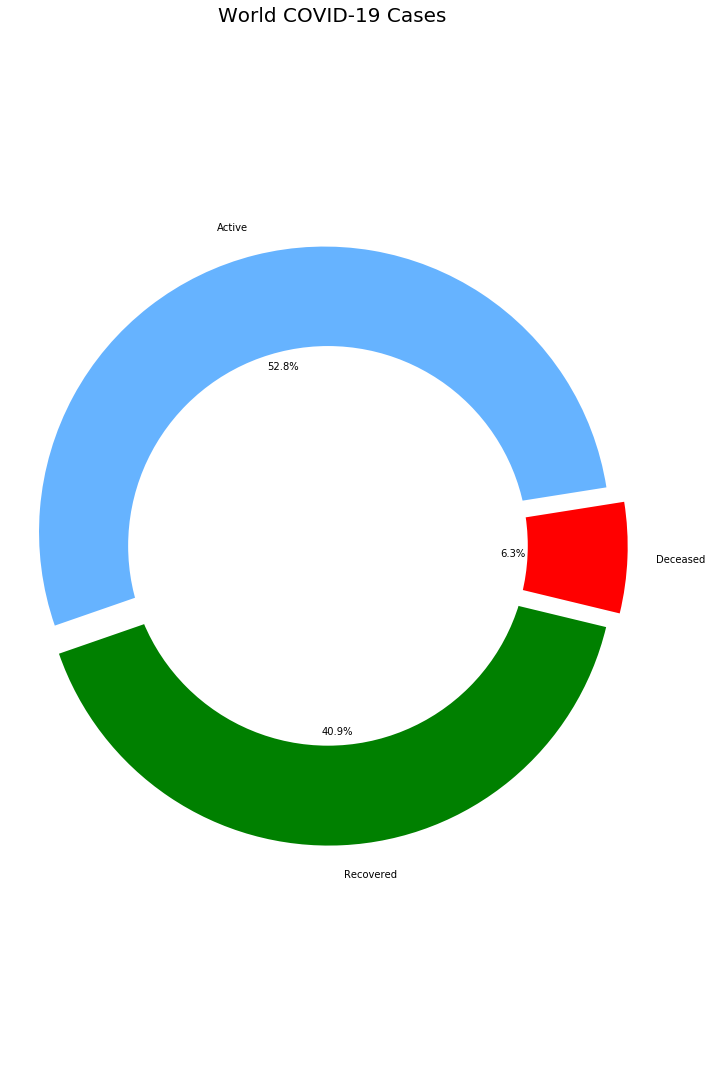

In [6]:
labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['#66b3ff','green','red']
explode = []
for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (10,15))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

In [7]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,946,948,949,964,969,981,989,998,1004,1029
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,761,761,761,762,762,762,762,762,763,763
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,48,50,52,52,58,60,61,69,70,70


In [8]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
# dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

In [9]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))

In [12]:
hotspots = ['China','Germany','Iran','Italy','Spain','United States','South Korea','France','Turkey','United Kingdom','India']
country_death_rate = pd.DataFrame(columns = ['country','day1','day2','day3'])
world_population['Population (2020)'] = world_population['Population (2020)']/1000000

d1=[]
d2 =[]
d3 = []
for country in hotspots:
    p = float(world_population[world_population['Country (or dependency)'] == country ]['Population (2020)'])
    if country == 'United States':
        k = global_deaths['US'][-3:]
    elif country == 'South Korea':
        k = global_deaths['Korea, South'][-3:]
    else:
        k = global_deaths[country][-3:]
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))

country_death_rate['country'] = hotspots
country_death_rate['day1'] = d1
country_death_rate['day2'] = d2
country_death_rate['day3'] = d3    

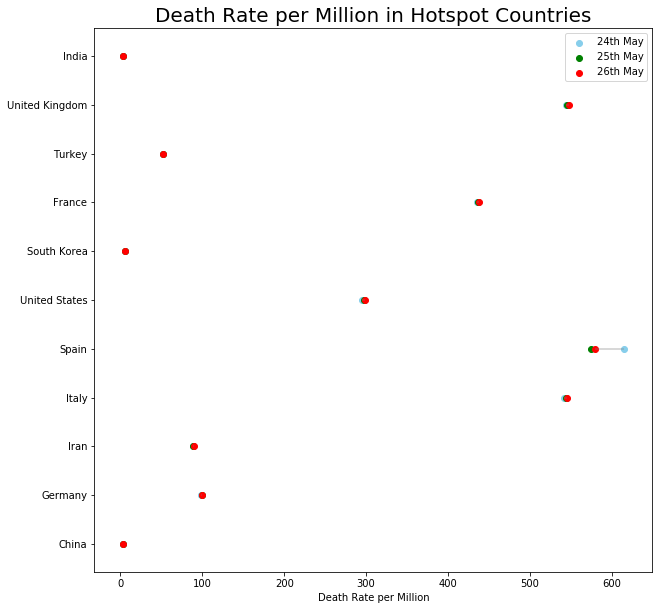

In [25]:
plt.figure(figsize= (10,10))
plt.hlines(y=country_death_rate['country'], xmin=country_death_rate['day1'], xmax=country_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(country_death_rate['day1'], country_death_rate['country'], color='skyblue', label='24th May');
plt.scatter(country_death_rate['day2'], country_death_rate['country'], color='green', label='25th May');
plt.scatter(country_death_rate['day3'], country_death_rate['country'], color='red', label='26th May');
plt.legend();
plt.title("Death Rate per Million in Hotspot Countries",fontsize=20);
plt.xlabel('Death Rate per Million');

### COVID in India

In [13]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

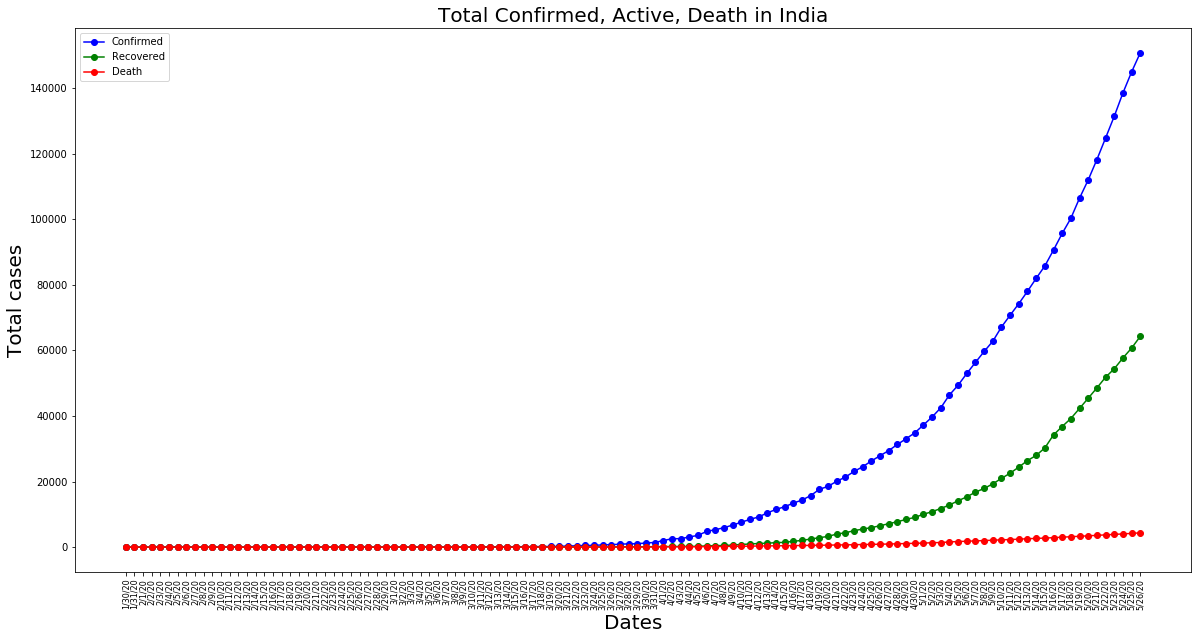

In [33]:
plt.figure(figsize= (20,10))
plt.xticks(rotation = 90 ,fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

#### Comparison to other countries

In [38]:
world_population.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438.207241,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377.233523,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330.610570,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272.931713,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219.992900,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [14]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []
population_value = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  
    
    pop = world_population[world_population['Country (or dependency)'] == country].loc[:,'Population (2020)']
    population_value.append(pop)


In [47]:
print(population_value[0])

0    1538.207241
Name: Population (2020), dtype: float64


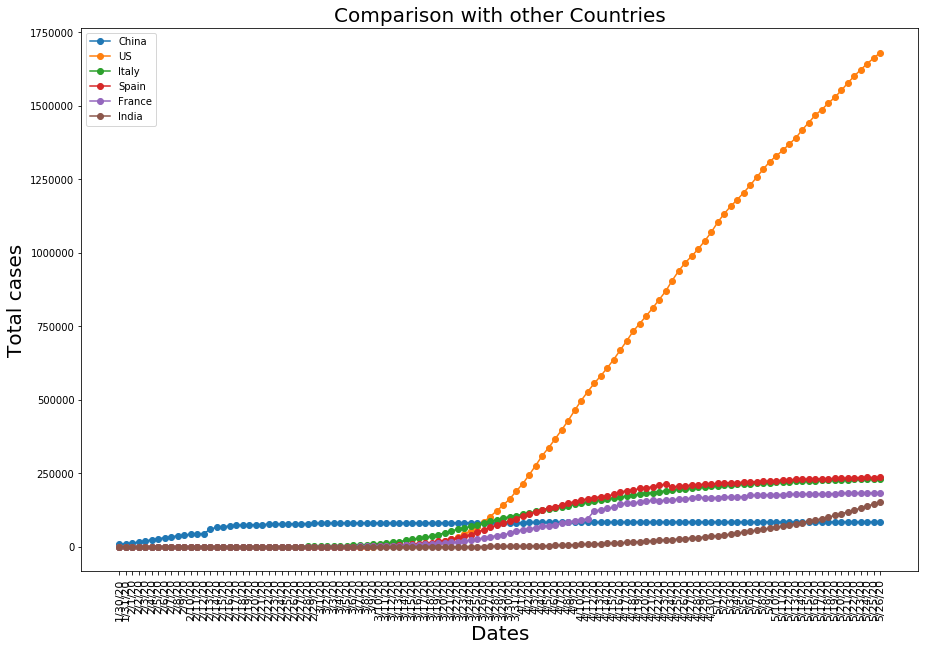

In [36]:
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

#### Age wise distribution

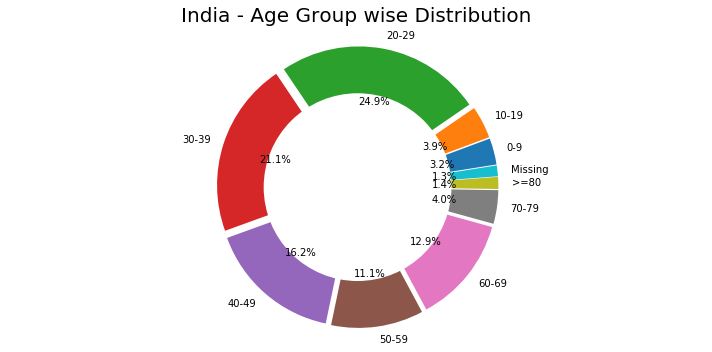

In [54]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (10,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

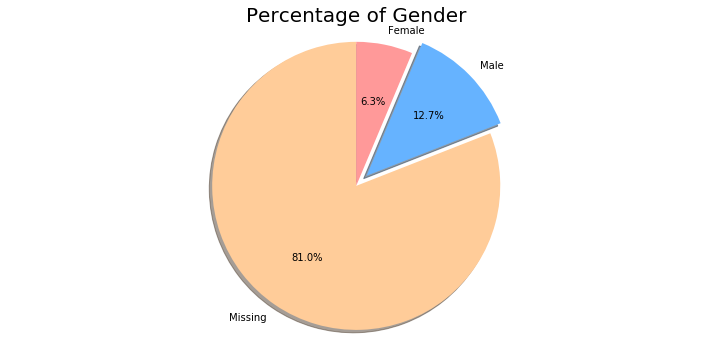

In [55]:
'''
We could see that the age group <40 is the most affected which is against the trend which says 
elderly people are more at risk of being affected. Only 17% of people >60 are affected
'''

labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']

plt.figure(figsize= (10,5))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

### Testing details

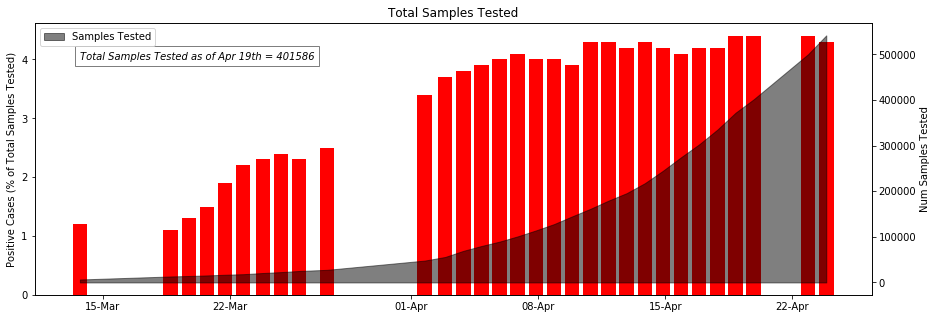

In [57]:
ICMR_details['Percent_positive'] = round((ICMR_details['TotalPositiveCases']/ICMR_details['TotalSamplesTested'])*100,1)

fig, ax1 = plt.subplots(figsize= (15,5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax1.set_ylabel('Positive Cases (% of Total Samples Tested)')
ax1.bar(ICMR_details['DateTime'] , ICMR_details['Percent_positive'], color="red",label = 'Percentage of Positive Cases')
ax1.text(ICMR_details['DateTime'][0],4, 'Total Samples Tested as of Apr 19th = 401586', style='italic',fontsize= 10,
        bbox={'facecolor': 'white' ,'alpha': 0.5, 'pad': 5})

ax2 = ax1.twinx()  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.set_ylabel('Num Samples Tested')
ax2.fill_between(ICMR_details['DateTime'],ICMR_details['TotalSamplesTested'],color = 'black',alpha = 0.5,label = 'Samples Tested');

plt.legend(loc="upper left")
plt.title('Total Samples Tested')
plt.show()

#### Statewise details

In [58]:
state_cases = india_covid_19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']- state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)

In [59]:
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
20,Maharashtra,52667,1695,15786,66758,3.220000,29.970000
30,Tamil Nadu,17082,118,8731,25695,0.690000,51.110000
11,Gujarat,14460,888,6636,20208,6.140000,45.890000
9,Delhi,14053,276,6771,20548,1.960000,48.180000
28,Rajasthan,7300,167,3951,11084,2.290000,54.120000
19,Madhya Pradesh,6859,300,3571,10130,4.370000,52.060000
34,Uttar Pradesh,6532,165,3581,9948,2.530000,54.820000
36,West Bengal,3816,278,1414,4952,7.290000,37.050000
1,Andhra Pradesh,3110,56,1896,4950,1.800000,60.960000
5,Cases being reassigned to states,2970,0,0,2970,0.000000,0.000000


In [61]:
all_state = list(india_covid_19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
#all_state.remove('Nagaland#')
#all_state.remove('Nagaland')
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]

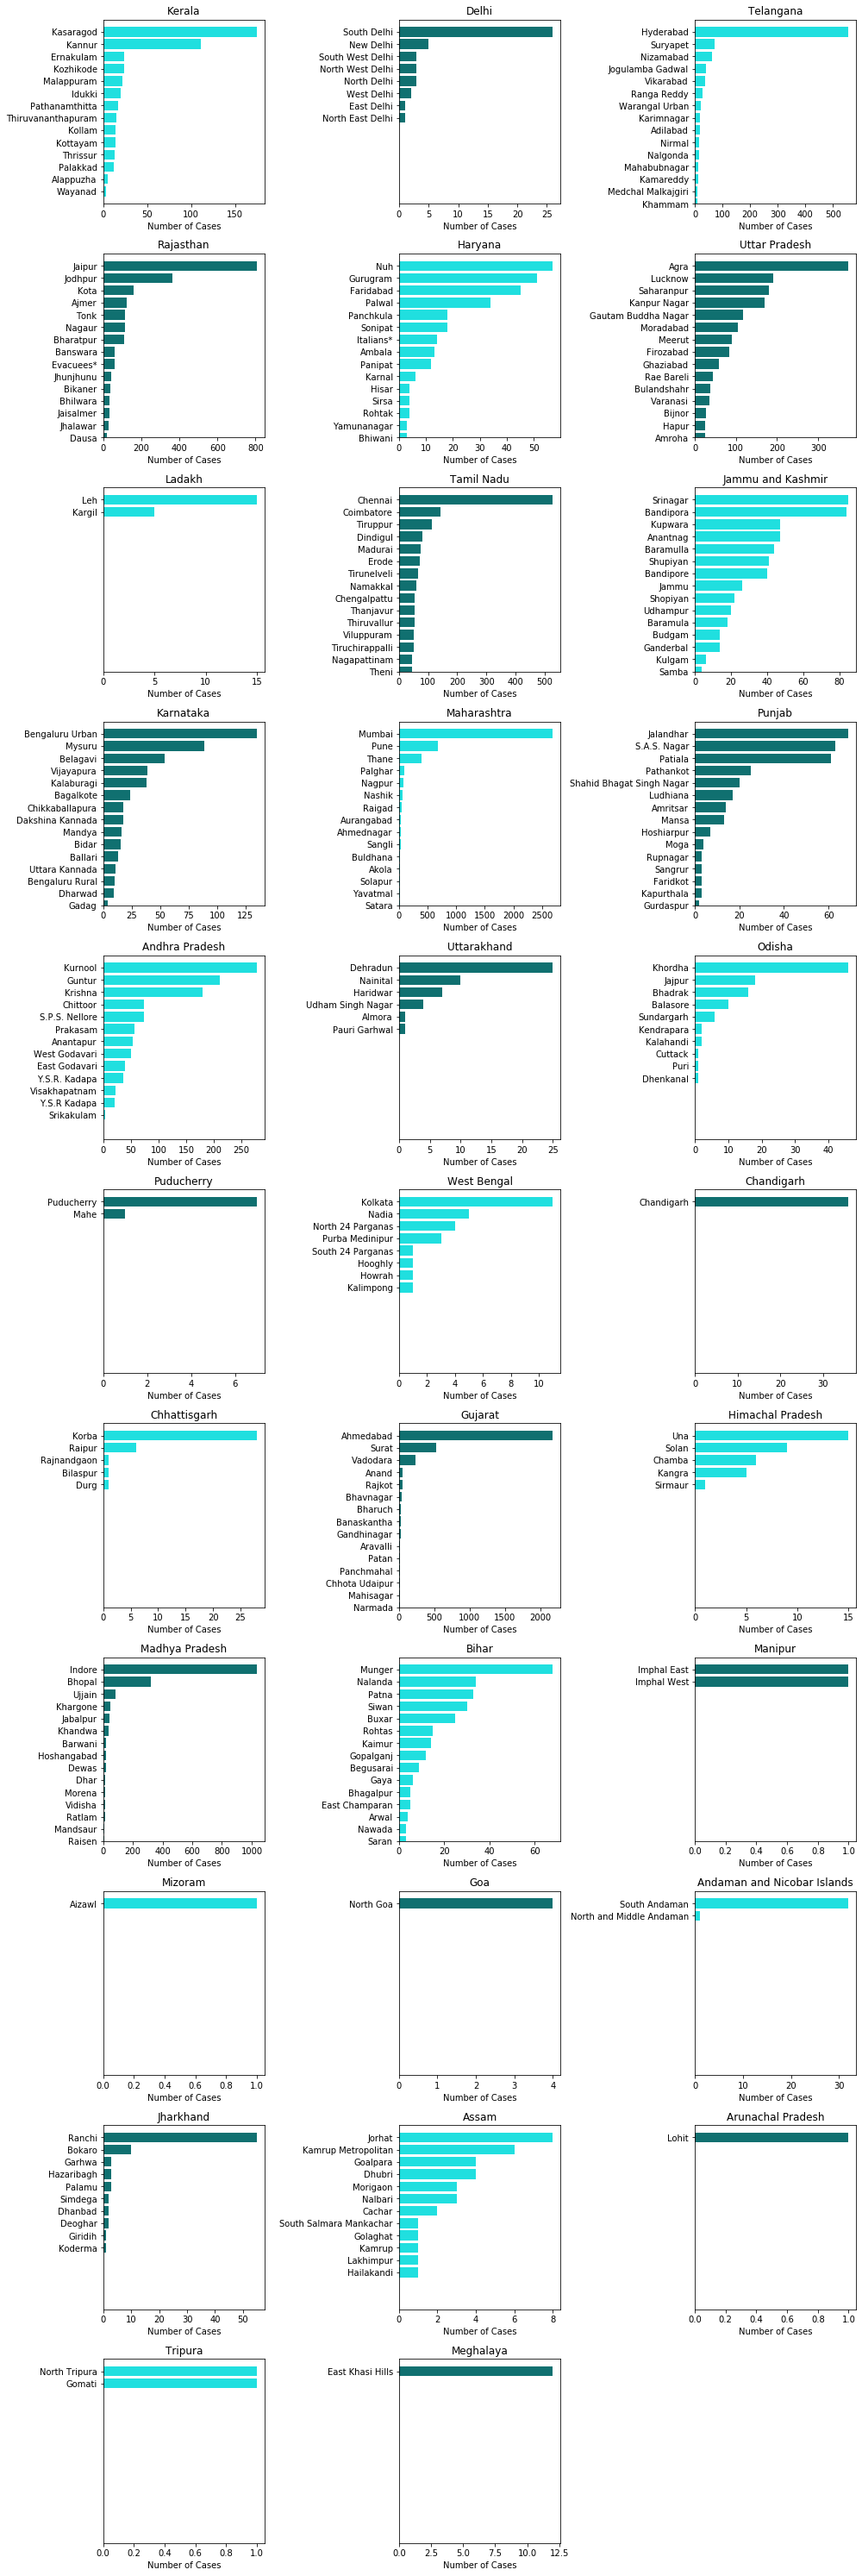

In [62]:
colors_list = ['cyan','teal']
states = individual_details['detected_state'].unique()
if len(states)%2==0:
    n_rows = int(len(states)/2)
else:
    n_rows = int((len(states)+1)/3)    
plt.figure(figsize=(14,60))

for idx,state in enumerate(states):    
    plt.subplot(n_rows,3,idx+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    try:
        g = sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',orient='v',color=colors_list[idx%2],order=y_order)
        plt.xlabel('Number of Cases')
        plt.ylabel('')
        plt.title(state)
        plt.ylim(14,-1)
    except:
        pass
plt.tight_layout()
plt.show()

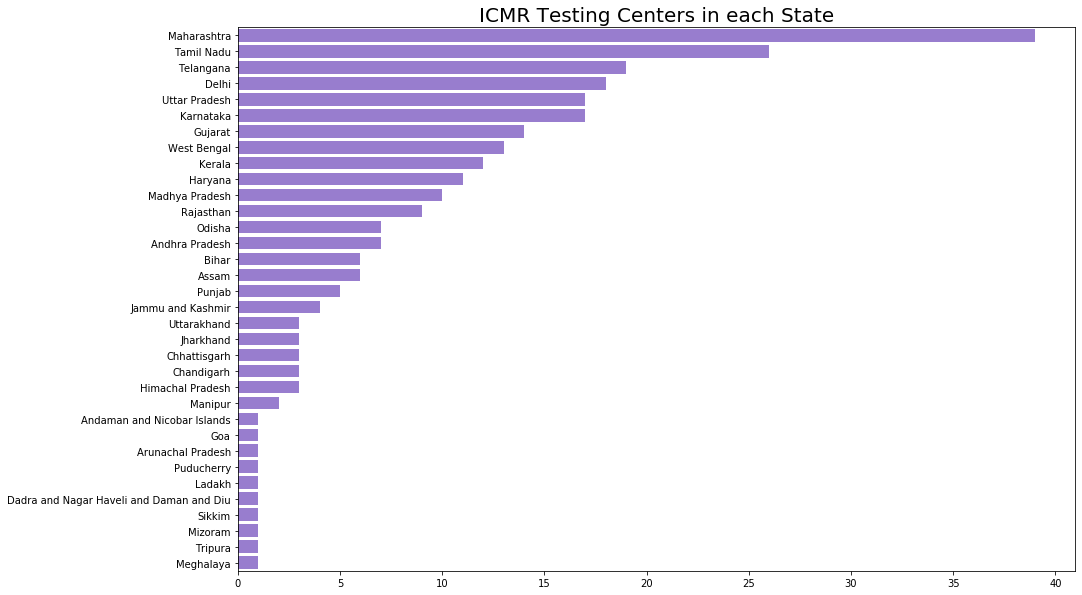

In [63]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#9370db');

### Growth rate of the cases

In [16]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.129914482388571


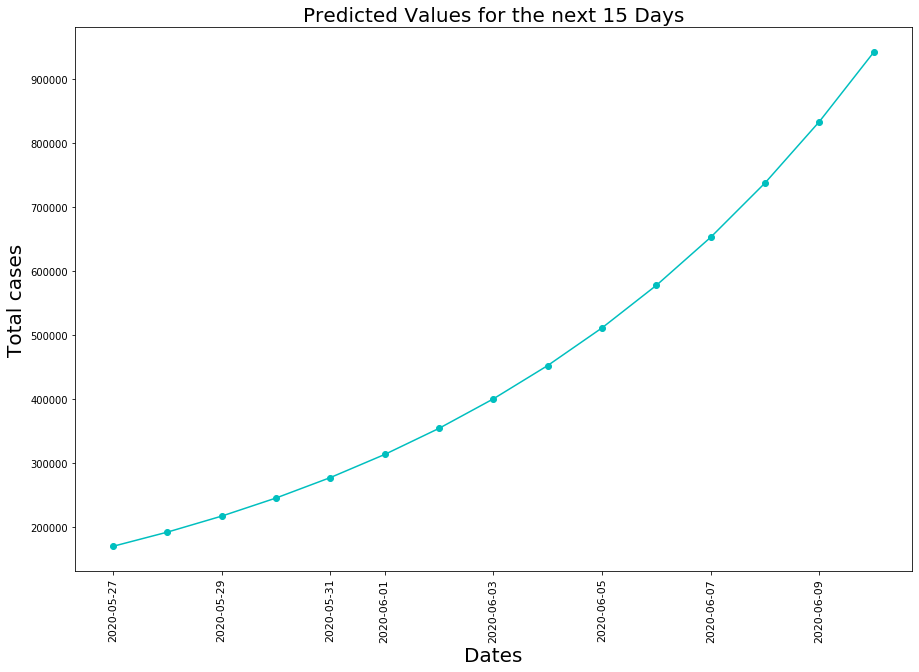

In [17]:
prediction_dates = []
dates = list(pd.to_datetime(dates))
date_india = dates[8:]
start_date = date_india[len(date_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(date_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')

#### Prediction for coming week

In [19]:
train3 = pd.read_csv('https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-global-forecasting-week-3/train.csv')
test3 = pd.read_csv('https://raw.githubusercontent.com/swathihameed/COVID/master/covid19-global-forecasting-week-3/train.csv')
train3['Date'] = pd.to_datetime(train3['Date'])
test3['Date'] = pd.to_datetime(test3['Date'])

In [20]:
train = train3
test = test3

In [21]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['quarter'] = train['Date'].dt.quarter
train['weekofyear'] = train['Date'].dt.weekofyear

test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['quarter'] = test['Date'].dt.quarter
test['weekofyear'] = test['Date'].dt.weekofyear

countries = list(train['Country_Region'].unique())
india_code = countries.index('India')
train = train.drop(['Date','Id'],1)
test =  test.drop(['Date'],1)

train.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
train[['Province_State','Country_Region']] = oe.fit_transform(train.loc[:,['Province_State','Country_Region']])

test.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
test[['Province_State','Country_Region']] = oe.fit_transform(test.loc[:,['Province_State','Country_Region']])

In [22]:
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State','Country_Region']
train = train[columns]
x = train.drop(['Fatalities','ConfirmedCases'], 1)
y = train['ConfirmedCases']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
test = test[test_columns]
test_india = test[test['Country_Region'] == india_code]


In [23]:
models = []
mse = []
mae = []
rmse = []